# Analyze Netflix Value - 2025
Netflix has increased their prices several times over the last few years, and I wonder how much value my household is currently getting out of our subscription.
Ascribing a objective value to a subjective experiance would be almost impossible, but we can still try. Using the metric *Cost per Hours Watched* ($/h) we can see how our much we are getting out of Netflix, where a lower number means more value.

First step is to gather the data from Netflix data, which I have already done for my account. To use your own data, follow the steps listed [here](./Gather%20Netflix%20Data.ipynb).

## Preparing Data: Viewing Activity

### Import Data

In [1]:
import pandas as pd
df_v = pd.read_csv(r'./files/view_activity_by_month.csv')
df_v.sample(n=5)

,Start Time,Duration
11707,2017-01-18 09:31:55,00:02:01
11658,2017-01-24 00:44:40,00:22:06
9376,2019-11-10 17:10:05,00:51:25
7056,2020-12-27 08:53:33,00:02:01
7640,2020-09-19 00:57:43,00:20:41


### Transform data

Before workking with the report we need to understand more about the overall data, starting with the datatype for each column

In [2]:
df_v.dtypes

Start Time    object
Duration      object
dtype: object

The columns `Duration` and `Start Time` need to be transformed into usable datatypes `datetime` and `timedelta`.

In [3]:
df_v['Start Time'] = pd.to_datetime(df_v['Start Time'], utc=True)
df_v['Duration'] = pd.to_timedelta(df_v['Duration'])

Now we can simplify this by summing up views per month.

In [4]:
df_vpm = df_v
df_vpm = df_vpm.set_index('Start Time')
df_vpm = df_vpm['Duration'].resample('MS').sum().to_frame()
df_vpm.sample(n=5)

,Duration
Start Time,
2016-10-01 00:00:00+00:00,0 days 05:24:53
2023-10-01 00:00:00+00:00,2 days 07:32:08
2021-08-01 00:00:00+00:00,0 days 13:54:02
2022-05-01 00:00:00+00:00,4 days 18:19:56
2021-09-01 00:00:00+00:00,1 days 05:03:39


In the final report we will want the Duration (viewing time) to be shown in in hours (h), so lets convert it.

In [5]:
import numpy as np

df_vpm['duration_h'] = df_vpm['Duration'] / np.timedelta64(1, 'h')
df_vpm.sample(n=5)

,Duration,duration_h
Start Time,,
2017-08-01 00:00:00+00:00,0 days 14:06:54,14.115000
2017-01-01 00:00:00+00:00,2 days 18:40:43,66.678611
2010-05-01 00:00:00+00:00,0 days 00:44:56,0.748889
2025-06-01 00:00:00+00:00,2 days 14:38:37,62.643611
2021-03-01 00:00:00+00:00,1 days 04:13:12,28.220000


### Visualize

Lets see how this data looks.

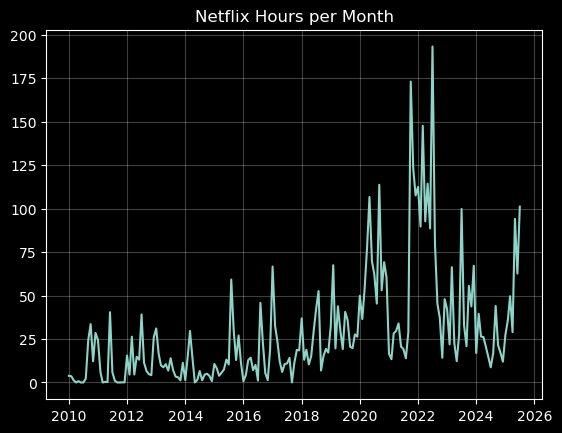

In [6]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.patheffects as pe

plt.style.use('dark_background')

v_fig, v_ax = plt.subplots()

v_ax.set_title("Netflix Hours per Month")
v_ax.plot(df_vpm.index, df_vpm.duration_h)
plt.grid(visible=True, alpha=0.25)

## Preparing Data: Billing

Next we want to get the subscription cost per month.

### Import Data

In [7]:
import pandas as pd

df_b = pd.read_csv(rf'./files/billing_by_month.csv')
df_b.sample(n=5)

,Service Period Start Date,Gross Sale Amt
19,2023-12-01,22.99
39,2022-04-02,15.49
73,2019-06-02,12.99
18,2024-01-01,22.99
67,2019-12-02,12.99


### Transform Data

Again we want to look at the the type of data in each column

In [8]:
df_b.dtypes

Service Period Start Date     object
Gross Sale Amt               float64
dtype: object

Both columns need to be transformed in some way: their names are going to be updated for ease-of-use later, and the datatype of  `Service Period Start Date` needs to be changed to to`datetime`,

In [9]:
df_b.rename(columns={'Gross Sale Amt': 'gross_sale_amt', 'Service Period Start Date': 'date'}, inplace=True)
df_b.date = pd.to_datetime(df_b.date, utc=True)
df_b.sample(n=5)

,date,gross_sale_amt
25,2023-06-02 00:00:00+00:00,15.49
44,2021-11-02 00:00:00+00:00,13.99
33,2022-10-02 00:00:00+00:00,15.49
11,2024-08-01 00:00:00+00:00,22.99
5,2025-02-01 00:00:00+00:00,22.99


Some of those dates are *not* on the first of the month, which will cause merging errors later if we don't handle it now.

In [10]:
df_b.date = df_b.date.apply(lambda x: x.replace(day=1))
df_b.sample(n=5)

,date,gross_sale_amt
22,2023-09-01 00:00:00+00:00,19.99
52,2021-03-01 00:00:00+00:00,13.99
3,2025-04-01 00:00:00+00:00,24.99
15,2024-04-01 00:00:00+00:00,22.99
76,2019-03-01 00:00:00+00:00,10.99


### Visualize

Lets look at the rising cost of my Netflix subscription.

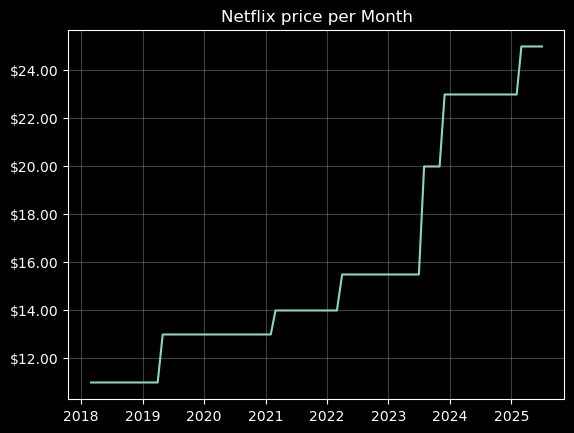

In [11]:
b_fig, b_ax = plt.subplots()

b_ax.set_title("Netflix price per Month")

b_ax.plot(df_b.date, df_b.gross_sale_amt)
b_ax.yaxis.set_major_formatter(lambda x, _: f'${x:1.2f}')
plt.grid(visible=True, alpha=0.25)

## Combine data

### Transform Data


Next we merge the data. Looking at the charts we already made the viewing data goes back to 2010 while the billing data only goes back to 2018. In the future it might be worth looking into where those missing billing years went, but for now we will continue with the data we have. The main action for this is to make sure that we merge onto the billing data so that any viewing data automatically gets left off if it is missing a match in the billing data.

In [12]:
df = pd.merge(df_b, df_vpm, how='left', left_on='date', right_on='Start Time')
df.sample(n=5)

,date,gross_sale_amt,Duration,duration_h
13,2024-06-01 00:00:00+00:00,22.99,0 days 14:40:49,14.680278
70,2019-09-01 00:00:00+00:00,12.99,0 days 20:34:25,20.573611
36,2022-07-01 00:00:00+00:00,15.49,8 days 01:13:39,193.227500
60,2020-07-01 00:00:00+00:00,12.99,2 days 14:04:52,62.081111
51,2021-04-01 00:00:00+00:00,13.99,1 days 05:42:29,29.708056


The last step before we make our final charts is to add in the metric of Cost per Hour that laid out at the beginning.

In [13]:
df['dollars_per_hour'] = df.gross_sale_amt/df.duration_h 
df.sample(n=5)

,date,gross_sale_amt,Duration,duration_h,dollars_per_hour
87,2018-04-01 00:00:00+00:00,10.99,0 days 10:20:03,10.334167,1.063463
13,2024-06-01 00:00:00+00:00,22.99,0 days 14:40:49,14.680278,1.566047
11,2024-08-01 00:00:00+00:00,22.99,0 days 16:53:19,16.888611,1.361272
43,2021-12-01 00:00:00+00:00,13.99,4 days 11:33:42,107.561667,0.130065
80,2018-11-01 00:00:00+00:00,10.99,0 days 19:17:24,19.290000,0.569725


### Visualize

Now we can chart the data. We'll create two charts, one that combines the viewing data and the billing data, and another that charts the Cost per Hour.

Text(0, 0.5, 'Cost Per Month ($)')

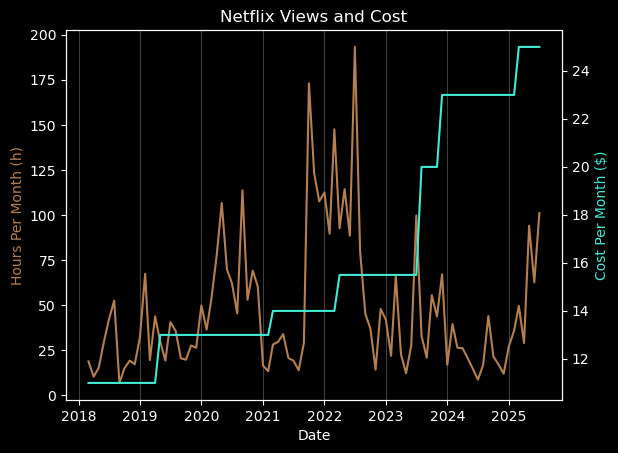

In [14]:
bg_color = '#2E5266'
ax1_color = '#b57f50'
ax2_color = '#41ead4'
ax3_color = '#B57F50'
plt.style.use('dark_background')

vb_fig, vb_ax1 = plt.subplots()
vb_ax1.set_facecolor = bg_color

vb_ax1.set_title("Netflix Views and Cost")
vb_ax1.plot(df.date, df.duration_h, color = ax1_color)

vb_ax1.set_xlabel('Date')
vb_ax1.set_ylabel('Hours Per Month (h)', color = ax1_color)
vb_ax1.grid(axis='x', alpha=0.25)

vb_ax2 = vb_ax1.twinx()
vb_ax2.plot(df.date, df.gross_sale_amt, color = ax2_color)
vb_ax2.set_ylabel('Cost Per Month ($)', color = ax2_color)

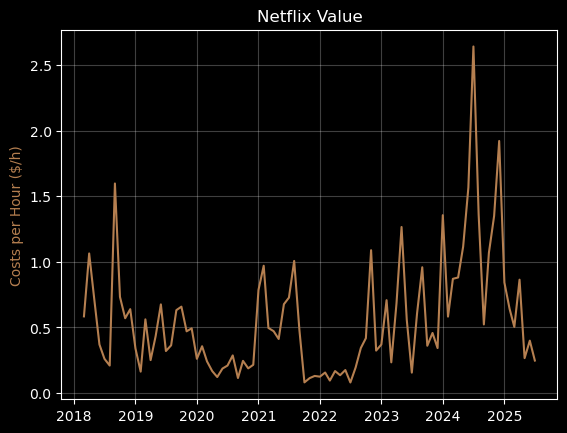

In [15]:
from collections import namedtuple
Point = namedtuple('Point', 'x y')

dph_x = df.date
dph_y = df.dollars_per_hour

dph_fig, dph_ax = plt.subplots()
dph_ax.set_title('Netflix Value')

dph_ax.set_ylabel('Costs per Hour ($/h)', color = ax3_color)

l_cph = dph_ax.plot(dph_x, dph_y, color = ax3_color)
l_cph = l_cph.pop()
dph_ax.grid(axis='both', alpha=0.25)

We'll add two labels, one for highest cost

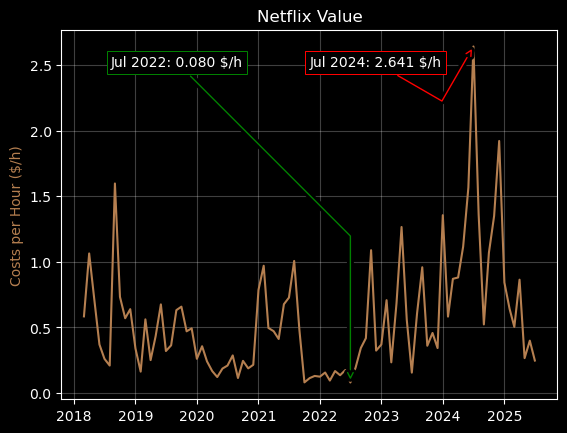

In [16]:
dph_max_color = 'red'
dph_min_color = 'green'

dph_max = Point(dph_x[np.argmax(dph_y)], dph_y.max())
dph_min = Point(dph_x[np.argmin(dph_y)], dph_y.min())

dph_max_box = dict(boxstyle="square,pad=0.3", fc="k", ec=dph_max_color, lw=0.72)
dph_min_box = dict(boxstyle="square,pad=0.3", fc="k", ec=dph_min_color, lw=0.72)

dph_max_arrow = dict(arrowstyle="->",connectionstyle="angle,angleA=-30,angleB=60", color=dph_max_color, path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
dph_min_arrow = dict(arrowstyle="->",connectionstyle="angle,angleA=-45,angleB=90", color=dph_min_color, path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])

dph_max_kw = dict(xycoords='data', textcoords="axes fraction", arrowprops=dph_max_arrow, bbox=dph_max_box)
dph_min_kw = dict(xycoords='data', textcoords="axes fraction", arrowprops=dph_min_arrow, bbox=dph_min_box)

dph_ann_max = dph_ax.annotate(f"{dph_max.x:%b %Y}: {dph_max.y:0.3f} $/h", xy=dph_max, xytext=(0.5, 0.9), **dph_max_kw)
dph_ann_min = dph_ax.annotate(f"{dph_min.x:%b %Y}: {dph_min.y:0.3f} $/h", xy=dph_min, xytext=(0.1, 0.9), **dph_min_kw)
dph_fig

Next is to look at any possible trends. 

While the data seems to have a general trend it is hard to see, so lets remove the previous annotations, add in a trend line, and fade out the month-to-month line.

In [17]:
dph_ann_min.remove()
dph_ann_max.remove()

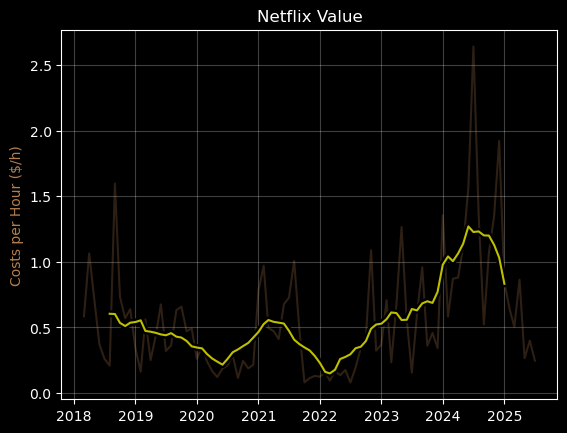

In [18]:
dph_t = df.dollars_per_hour.rolling(window=12, center=True).mean()
dph_ax.plot(dph_x, dph_t,  color='y', path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
l_cph.set_alpha(.25)
dph_fig

The trend is showing that up until 2024 the cost per hour was below $0.75 with an increase end of 2023/ beginning of 2024. That might be related to when the price increases went into effect.

A feature that would help show if that is correct would be gridlines for the x-axis for months when the increase occured.

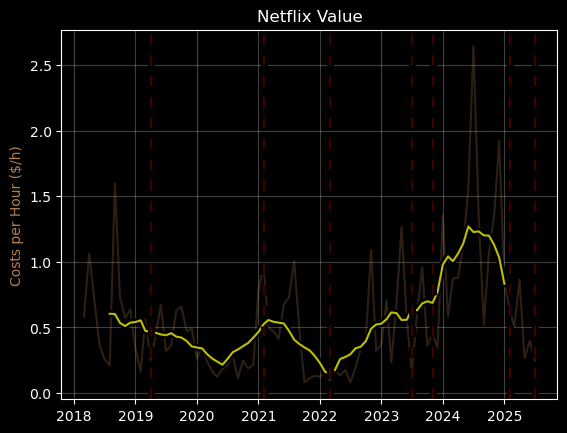

In [19]:
#get price increase months
pim = df_b.loc[df_b.gross_sale_amt.ne(df_b.gross_sale_amt.shift())].date

[dph_ax.axvline(x=d, color='r', alpha=.25, dashes=(5, 5, 5, 5), path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()]) for d in pim]

dph_fig


## Conclusions

In 2024 our household cost-per-hour of our Netflix subscription has increased, where our *best* price in 2024 is higher than our *worst* price every other year. Looking just at the data from Netflix is unclear as to the reason. At this moment we will continue to hold our Netflix subscription as it is still costing less that $2 an hour. Unfortuantly we don't have a goalpost that we are aiming at, so any action would be based on how we feel about that cost instead of have a number we are trying to beat. However looking at 2025 the cost is beginning to decrease again, so the value is still there in some capacity.

### Possible Reasons for 2024 decreased value

* The Netflix viewing was replaced by some other media consumption
    * Books
        * In 2023 all members of our household signed up for the Library Audiobook App [**Libby**](https://libbyapp.com/), and overall reading (physical, digital, and audio) has increase in household
    * Other Streaming services were watched instead
        * Several more streaming services that didn't exists several years ago
        * Our already owned physical media collections (DVD/Blu Ray/etc) have been ripped onto a local Homelab server.

## Next Steps

### Create & Run more Cost-per-Hour reports

* Run this report again in six months to re-evaluate.
* Create comparable Analysis reports for our other programing services.

### Dive deeper into the Netflix Data

There are some other questions that I would like to expore with the data that i already have

* What profile watched the most programing?
* What program (as individual movie or entire TV series) has the most unique views
    * for TV shows, is one episode watched more than any other?
* What is the min, max and meanfor how long is Netflix watched before exiting the app?
* What device has the most views?
* Which device is used by each profile?
* What titles have been watched by all profiles?

### Exlopre New data tools

* Use exisiting data to practice using AI-enhanced tools
    * [Googles AI for Data Analytics](https://cloud.google.com/use-cases/ai-data-analytics)
    * [ChatGPT Data Analyst](https://chatgpt.com/g/g-HMNcP6w7d-data-analyst)